In [ ]:
!pip install rasterio

In [ ]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [ ]:
dem = rio.open('dem.tif')
dem_array = dem.read(1).astype('float64')
dem_array.shape

(320, 216)

In [ ]:
print(np.mean(dem_array))

3552.1549189814814


In [ ]:
slope = rio.open('slope.tif')
slope_array = slope.read(1).astype('float64')
slope_array.shape

(320, 216)

In [ ]:
np.max(slope_array)

64.08726501464844

In [ ]:
aspect = rio.open('aspect.tif')
aspect_array = aspect.read(1).astype('float64')
aspect_array.shape

(320, 216)

In [ ]:
np.mean(aspect_array)

161.1970685272249

In [ ]:
points = rio.open('imp_points.tif')
points_array = points.read(1).astype('float64')
points_array.shape

(320, 216)

In [ ]:
start_pix = np.argwhere(points_array == 1)
start_pix = np.squeeze(start_pix)
start_pix

array([289, 128])

In [ ]:
end_pix = np.argwhere(points_array == 3)
end_pix = np.squeeze(end_pix)
end_pix

array([21, 90])

In [ ]:
check_pixs = np.argwhere(points_array == 2)
check_pixs =np.squeeze(check_pixs)
check_pixs

array([[101,  83],
       [207,  86]])

In [ ]:
rewards = (np.ones((320,216,4))) * -1000
rewards.shape

(320, 216, 4)

In [ ]:
rewards[1,1,1]

-1000.0

In [ ]:
rewards[287,134,:]

array([-1000., -1000., -1000., -1000.])

based on elevation

In [ ]:
def reward_calculator(current_pos,next_pos):
  c = current_pos
  n = next_pos
  if (c <= n):
    reward = (np.abs(c-n)+1)/1000  #so going up the reward is -1
    pass
  elif (c > n):
    reward = (np.abs(c-n)+1)/100 # so going down reward is -10
    pass
  return reward



In [ ]:
row,col,dim = rewards.shape
for rr in range(row-4):
  for cc in range(col-4):
    r= rr + 2
    c= cc + 2
    rewards[r,c,0] = -reward_calculator(dem_array[r,c],dem_array[r-1,c]) #going up
    rewards[r,c,1] = -reward_calculator(dem_array[r,c],dem_array[r,c+1]) #going right
    rewards[r,c,2] = -reward_calculator(dem_array[r,c],dem_array[r+1,c]) #going down
    rewards[r,c,3] = -reward_calculator(dem_array[r,c],dem_array[r,c-1]) #going left

testing what is the max elevation difrenct between two adjacent pixels

In [ ]:
x = []
for rr in range(row-4):
  for cc in range(col-4):
    r= rr + 2
    c= cc + 2
    x.append(dem_array[r,c] - dem_array[r+1,c] )
    x.append(dem_array[r,c] - dem_array[r-1,c] )
    x.append(dem_array[r,c] - dem_array[r,c+1] )
    x.append(dem_array[r,c] - dem_array[r,c-1] )

In [ ]:
y =np.abs(x)

In [ ]:
np.max(x)

99.0

In [ ]:
rewards[299,131,:]

array([-0.017, -0.001, -0.46 , -0.19 ])

In [ ]:
rewards[289,127,:]

array([-0.01 , -0.007, -0.06 , -0.001])

In [ ]:
rewards[42,40,:]

array([-0.003, -0.008, -0.05 , -0.08 ])

In [ ]:
type(dem_array)

numpy.ndarray

In [ ]:
np.max(dem_array)

5599.0

In [ ]:
print(dem_array.shape)

(320, 216)


In [ ]:
#define the shape of the environment (i.e., its states)
environment_rows = (dem_array.shape)[0]
environment_columns = (dem_array.shape)[1]

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a) 
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions). 
#The value of each (state, action) pair is initialized to 0.


#q_values = np.zeros((environment_rows, environment_columns, 4))
q_values = np.load('qnp.npy')

In [ ]:
q_values.shape

(320, 216, 4)

#### Actions
The actions that are available to the AI agent are to move the robot in one of four directions:
* Up
* Right
* Down
* Left

Obviously, the AI agent must learn to avoid driving into the item storage locations (e.g., shelves)!


In [ ]:
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

In [ ]:
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index,end_pix):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if np.min(rewards[current_row_index, current_column_index,:]) == -1000 :
    print(current_row_index,current_column_index)
    return True
  elif (current_row_index==end_pix[0] and current_column_index == end_pix[1]):
    print("HIT!")
    return True
    
  else:
    return False

#define a function that will choose a random, non-terminal starting location
def get_starting_location(start_pix):
  #get a random row and column index
  current_row_index = start_pix[0]
  current_column_index = start_pix[1]
  return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon, 
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

def environment_effect(current_row_index, current_column_index,action):
  asp = aspect_array[current_row_index,current_column_index]
  if asp >= 45 and asp<=135:
    new_action = 1
  elif asp >= 135 and asp<=225:
    new_action = 2
  elif asp >= 225and asp<=315:
    new_action = 3
  elif asp >= 315 and asp<=45:
    new_action = 0
  else:
    new_action = action
  slp = slope_array[current_row_index,current_column_index]
  q = ((slp/90)**10)/2 #probabilite of environmnet changin the action
  p = 1-q

  new_action = int(np.random.choice([action,new_action],1, p=[p,q]))
  return new_action





#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

#Define a function that will get the shortest path between any location within the warehouse that 
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index,end_pix ,epsilon=1.,log=True):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index,end_pix):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index,end_pix):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, epsilon)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
      if log:print([current_row_index, current_column_index])
    return shortest_path

In [ ]:
is_terminal_state(21,90,end_pix)

HIT!


True

#### Train the AI Agent using Q-Learning

In [ ]:
rewards[10,10,3]

-0.14

In [ ]:
#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.1 #the rate at which the AI agent should learn
EPISODES =1000
#run through 1000 training episodes
for episode in range(EPISODES):
  epsilon = 0.9*((episode+10)/EPISODES)
  learning_rate = 0.5 - 0.45*((episode+10)/EPISODES)
  if episode%100 == 0: 
    print("episode: " + str(episode))
    print("learning rate: " + str(learning_rate))
    print("epsilon: " + str(epsilon))
  #get the starting location for this episode
  row_index, column_index = get_starting_location(start_pix)

  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
  check1_on = True
  check2_on = True
  while not is_terminal_state(row_index, column_index, end_pix):
    #choose which action to take (i.e., where to move next)
    action_index = get_next_action(row_index, column_index, epsilon)
    env_action = environment_effect(row_index, column_index, action_index)
    #env_action = action_index
    #perform the chosen action, and transition to the next state (i.e., move to the next location)
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, env_action)
    
    #receive the reward for moving to the new state, and calculate the temporal difference

    if row_index == end_pix[0] and column_index == end_pix[1]:
      reward = 100
      print('HIT CONFIRMED!')
    elif (row_index == check_pixs[0][0] and column_index == check_pixs[0][1]) and check1_on:
      reward = 100
      print("CHECK_1 !",str(episode))
      check1_on = False
    elif (row_index == check_pixs[1][0] and column_index == check_pixs[1][1]) and check2_on:
      reward = 100
      print("CHECK_2 !",str(episode))
      check2_on = False
    else:
      reward = rewards[old_row_index,old_column_index,env_action]

    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #update the Q-value for the previous state and action pair
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

episode: 0
learning rate: 0.4955
epsilon: 0.009000000000000001
318 83
318 141
318 45
200 1
318 178
318 147
CHECK_2 ! 6
HIT CONFIRMED!
HIT!
318 181
156 214
318 118
318 114
306 214
318 117
46 1
283 214
318 104
225 214
318 67
HIT CONFIRMED!
HIT!
CHECK_1 ! 19
35 1
318 127
318 69
CHECK_2 ! 22
HIT CONFIRMED!
HIT!
318 116
318 78
273 1
318 157
1 56
318 88
HIT CONFIRMED!
HIT!
318 126
318 142
CHECK_2 ! 32
1 195
318 125
197 214
CHECK_2 ! 35
HIT CONFIRMED!
HIT!
318 61
HIT CONFIRMED!
HIT!
318 143
CHECK_2 ! 39
HIT CONFIRMED!
HIT!
CHECK_2 ! 40
227 1
318 171
221 1
318 141
318 149
261 214
HIT CONFIRMED!
HIT!
318 41
318 146
318 128
CHECK_2 ! 50
HIT CONFIRMED!
HIT!
HIT CONFIRMED!
HIT!
254 1
277 1
HIT CONFIRMED!
HIT!
318 102
318 154
HIT CONFIRMED!
HIT!
318 122
257 214
HIT CONFIRMED!
HIT!
318 83
CHECK_2 ! 62
149 1
HIT CONFIRMED!
HIT!
CHECK_2 ! 64
HIT CONFIRMED!
HIT!
268 1
318 143
HIT CONFIRMED!
HIT!
CHECK_2 ! 68
CHECK_1 ! 68
HIT CONFIRMED!
HIT!
CHECK_2 ! 69
HIT CONFIRMED!
HIT!
CHECK_2 ! 70
104 1
188 214
31

KeyboardInterrupt: ignored

## Get Shortest Paths
Now that the AI agent has been fully trained, we can see what it has learned by displaying the shortest path between any location in the warehouse where the robot is allowed to travel and the item packaging area.


Run the code cell below to try a few different starting locations!

In [ ]:
q_values[287,133,:]

HIT!
[[289, 128], [289, 129], [289, 130], [289, 131], [289, 132], [289, 133], [289, 134], [289, 135], [288, 135], [288, 134], [289, 134], [289, 135], [288, 135], [288, 134], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [287, 133], [287, 134], [286, 134], [285, 134], [284, 134], [283, 134], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133], [282, 134], [282, 133]

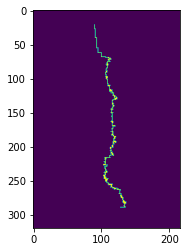

In [ ]:
#display a few shortest paths
path =get_shortest_path(start_pix[0], start_pix[1],end_pix,epsilon =0.95,log=False)
print(path) #starting at row 3, column 9

pathimg = np.zeros((320,216))
path_array  =np.array(path)

for i in path_array:
  pathimg[i[0],i[1]] =1

plt.imshow(pathimg)
plt.show()

In [ ]:
m =plt.imread('mainpath.tif')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(m*125)
ax2.imshow(pathimg)


In [ ]:
for i in path_array:
  pathimg[i[0],i[1]] =125
plt.imsave('result.jpg',pathimg)
plt.imshow(pathimg)
plt.show()

In [ ]:
np.save("resultarray.npy",pathimg)

In [ ]:
pathimg = np.zeros((320,216))

In [ ]:
path_array  =np.array(path)

In [ ]:
path_array[1]

In [ ]:
for i in path_array:
  pathimg[i[0],i[1]] =1

In [ ]:
plt.imshow(pathimg)
plt.show()

In [ ]:
print(np.min(q_values))

In [ ]:
q_values.shape

In [ ]:
#np.save("qnp.npy",q_values)

In [ ]:
x = np.load('qnp.npy')

In [ ]:
np.max(x)